<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [67]:
'''Base stuff'''
import os
import re

import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import spacy

from collections import Counter

''' Gensim Stuff '''
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import SnowballStemmer

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [68]:
import bs4
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd

job_df = pd.DataFrame([], columns=['title',"description"])

def job_info(url):
    """Scrapes data from individual job posts"""
    html_doc = requests.get(url)
    soup = bs(html_doc.content, 'html.parser')
    all_content = soup.find('div',class_='jobsearch-ViewJobLayout-jobDisplay icl-Grid-col icl-u-xs-span12 icl-u-lg-span7')
    try:
        title = all_content.find('h3').text.strip()
    except:
        title = np.NaN
    try:
        description = all_content.find('div',class_='jobsearch-jobDescriptionText').text.strip()
    except:
        description = np.NaN
    df = pd.DataFrame({'title':[title],'description':[description]})
    return(df)

def job_links(url):
    """Collects the links for all the listing on a search results page."""
    html_doc = requests.get(url)
    soup = bs(html_doc.content, 'html.parser')
    all_content = soup.find_all('div',class_='title')
    link_list = []
    for i in all_content:
        link = i.find('a', class_='jobtitle')['href']
        link_list.append(f"https://www.indeed.com{link}")
 
    return(link_list)

for i in range(0,100,10):
    #takes the indeed search link with the search parameters and iterates over the first 9 pages of results
    #Note: q= the search query l= the location start= page number. Example: page 1 is 0, page 2 is 10, page 3 is 20
    url = 'https://www.indeed.com/jobs?q=data+scientist&l=Salt+Lake+City%2C+UT&start=0'+str(i)
    print(url)
    jobs = job_links(url)
    for job in jobs:
        df = job_info(job)
        job_df = job_df.append(df)

https://www.indeed.com/jobs?q=data+scientist&l=Salt+Lake+City%2C+UT&start=00
https://www.indeed.com/jobs?q=data+scientist&l=Salt+Lake+City%2C+UT&start=010
https://www.indeed.com/jobs?q=data+scientist&l=Salt+Lake+City%2C+UT&start=020
https://www.indeed.com/jobs?q=data+scientist&l=Salt+Lake+City%2C+UT&start=030
https://www.indeed.com/jobs?q=data+scientist&l=Salt+Lake+City%2C+UT&start=040
https://www.indeed.com/jobs?q=data+scientist&l=Salt+Lake+City%2C+UT&start=050
https://www.indeed.com/jobs?q=data+scientist&l=Salt+Lake+City%2C+UT&start=060
https://www.indeed.com/jobs?q=data+scientist&l=Salt+Lake+City%2C+UT&start=070
https://www.indeed.com/jobs?q=data+scientist&l=Salt+Lake+City%2C+UT&start=080
https://www.indeed.com/jobs?q=data+scientist&l=Salt+Lake+City%2C+UT&start=090


In [69]:
print(job_df.shape)
job_df.head()

(170, 2)


,title,description
0,Data Analyst-Statistical-Stf,Description:\nAbout Us\nBeing a part of Interm...
0,Data Scientist,"Central Logic, a leading provider of innovativ..."
0,Data Science Specialist USA,Note: This position is accepting applicants fo...
0,Quantitative Data Scientist,Identifies trends and problems through complex...
0,Data Scientist in Applied Artificial Intellige...,Data Scientist in Applied Artificial Intellige...


In [70]:
''' Cleaning text and preparing for NLP '''
STOPWORDS = set(STOPWORDS).union(set(['the', 'aa', 'aaa', 'aaaaaa' ]))

def tokenize(text): 
    return [token for token in simple_preprocess(text) if token not in STOPWORDS and len(token) >=3]

''' Throwing in some regex cleaning just for good measure '''
def clean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.replace('\n', '')
    
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [72]:
df = job_df

## 2) Use Spacy to tokenize / clean the listings 

In [73]:
df['tokens'] = df['description'].apply(tokenize, clean)
df.head()

,title,description,tokens
0,Data Analyst-Statistical-Stf,Description:\nAbout Us\nBeing a part of Interm...,"[description, intermountain, healthcare, means..."
0,Data Scientist,"Central Logic, a leading provider of innovativ...","[central, logic, leading, provider, innovative..."
0,Data Science Specialist USA,Note: This position is accepting applicants fo...,"[note, position, accepting, applicants, new, y..."
0,Quantitative Data Scientist,Identifies trends and problems through complex...,"[identifies, trends, problems, complex, big, d..."
0,Data Scientist in Applied Artificial Intellige...,Data Scientist in Applied Artificial Intellige...,"[data, scientist, applied, artificial, intelli..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [74]:
##### Your Code Here #####
vect = CountVectorizer()
text = df['tokens'].astype(str)
vect.fit(text)
dtm = vect.transform(text)

In [76]:
# words and word counts for every job listing.
print(dtm)

  (0, 5)	1
  (0, 23)	1
  (0, 30)	1
  (0, 31)	1
  (0, 32)	3
  (0, 44)	1
  (0, 51)	1
  (0, 60)	1
  (0, 65)	1
  (0, 94)	1
  (0, 140)	2
  (0, 141)	8
  (0, 143)	2
  (0, 144)	1
  (0, 146)	2
  (0, 147)	4
  (0, 148)	3
  (0, 151)	2
  (0, 167)	1
  (0, 176)	1
  (0, 180)	1
  (0, 181)	1
  (0, 182)	1
  (0, 183)	1
  (0, 192)	2
  :	:
  (169, 3286)	2
  (169, 3295)	1
  (169, 3301)	1
  (169, 3303)	1
  (169, 3360)	1
  (169, 3419)	1
  (169, 3454)	1
  (169, 3475)	1
  (169, 3485)	1
  (169, 3488)	1
  (169, 3491)	1
  (169, 3507)	1
  (169, 3515)	1
  (169, 3541)	1
  (169, 3545)	1
  (169, 3558)	1
  (169, 3560)	1
  (169, 3582)	1
  (169, 3604)	1
  (169, 3609)	1
  (169, 3622)	4
  (169, 3637)	1
  (169, 3640)	1
  (169, 3642)	1
  (169, 3659)	1


In [77]:
#checking feature names
feature_names = vect.get_feature_names()
feature_names[25]

'accordance'

In [78]:
'''Converting sparse matrix into dense matrix and creating dataframe using get_feature_names as column headers'''
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.head()

,aan,aaron,abbreviations,abilities,abilitiestrack,ability,able,abreast,absolutely,abstracts,...,yesterday,york,youtube,zealous,zealously,zero,zinamoukheiber,zions,zip,zones
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [79]:
##### Your Code Here #####
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

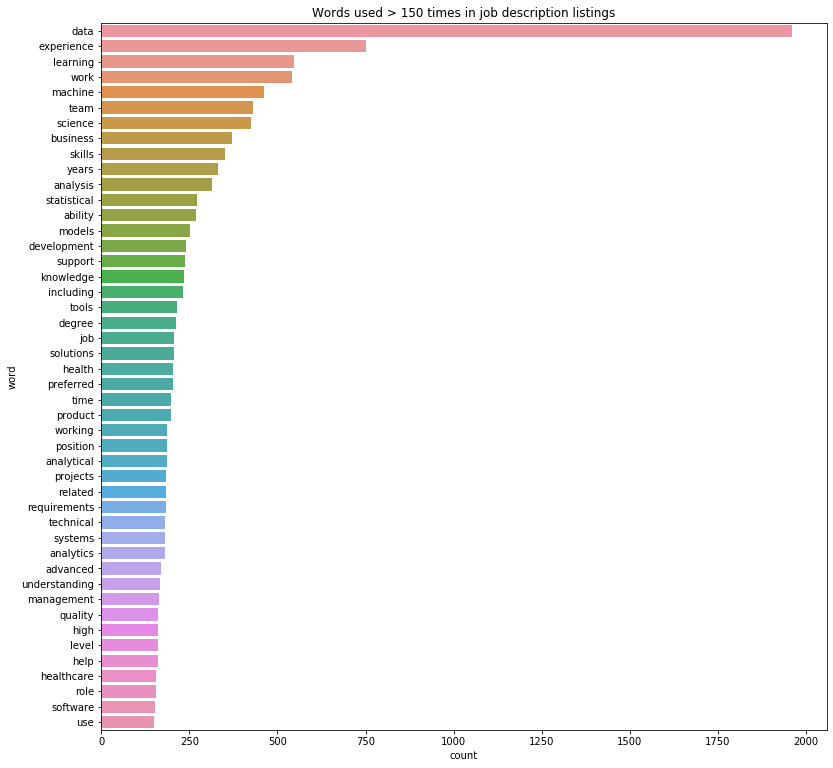

In [82]:
wc = count(df['tokens'])
wc.head()
sns.barplot(x='count', y='word', data=(wc[wc['count'] > 150]))
plt.title('Words used > 150 times in job description listings')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 13

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [83]:
##### Your Code Here #####
# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english')

# create list of text documents
text = df['tokens'].astype(str)

# Tokenize and build vocab
vect.fit(text)

# transform text to create feature matrix
dtm = vect.transform(text)

In [84]:
print(dtm)

  (0, 5)	1
  (0, 23)	1
  (0, 30)	1
  (0, 31)	1
  (0, 32)	3
  (0, 44)	1
  (0, 51)	1
  (0, 60)	1
  (0, 65)	1
  (0, 94)	1
  (0, 140)	2
  (0, 141)	8
  (0, 143)	2
  (0, 144)	1
  (0, 146)	2
  (0, 147)	4
  (0, 148)	3
  (0, 151)	2
  (0, 167)	1
  (0, 176)	1
  (0, 180)	1
  (0, 181)	1
  (0, 182)	1
  (0, 183)	1
  (0, 192)	2
  :	:
  (169, 3286)	2
  (169, 3295)	1
  (169, 3301)	1
  (169, 3303)	1
  (169, 3360)	1
  (169, 3419)	1
  (169, 3454)	1
  (169, 3475)	1
  (169, 3485)	1
  (169, 3488)	1
  (169, 3491)	1
  (169, 3507)	1
  (169, 3515)	1
  (169, 3541)	1
  (169, 3545)	1
  (169, 3558)	1
  (169, 3560)	1
  (169, 3582)	1
  (169, 3604)	1
  (169, 3609)	1
  (169, 3622)	4
  (169, 3637)	1
  (169, 3640)	1
  (169, 3642)	1
  (169, 3659)	1


In [85]:
# create pandas dataframe using sparse matrix above and get_feature_names as columns
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
print('TF-IDF Feature Matrix:')
dtm.head()

TF-IDF Feature Matrix:


,aan,aaron,abbreviations,abilities,abilitiestrack,ability,able,abreast,absolutely,abstracts,...,yesterday,york,youtube,zealous,zealously,zero,zinamoukheiber,zions,zip,zones
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [86]:
##### Your Code Here #####
from sklearn.neighbors import NearestNeighbors

#Instantiate NearestNeighbors model
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
# Fit NN model to TF-IDF feature matrix
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [87]:
ideal_job = ['''
Looking for a data science job where I can continue to learn and grow professionally.
Where I can apply machine learning and artificial intelligence algorithms to provide
solutions to common problems efficiently. Specifically, a place where neural networks
are built to analyze big imaging data. Biotech company with Competitive pay. 
I aim to work at a place where teamwork and collaboration are valued. 
I aim to build and apply convolutional neural networks for biological image analysis, 
and to use big data and statistics to engineer solutions to common problems in society
''']

In [88]:
new = vect.transform(ideal_job)
a = nn.kneighbors(new.todense())

In [89]:
a[0:2]

(array([[ 8.88819442, 13.60147051, 13.60147051, 13.7113092 , 14.03566885]]),
 array([[10, 68, 36,  6, 22]]))

In [94]:
print(df['description'].iloc[22])

Help design, develop and implement software to enhance Synoptic’s data access, storage, analytics and data mining capabilities. Other tasks may include enhancing the data API for geospatial scientific data or to design and develop applications to facilitate large data acquisition and dissemination using cloud computing services.

Minimum requirements: B.S. degree with computer programming experience related to solving scientific computing problems involving large data sets. Preferred: Familiarity with several of the following data integration and systems development technologies: Python, relational databases, API development and methodologies, software version control, cloud computing services. Candidate must be self-driven, accountable under minimal supervision to reach project goals, and comfortable working in a research environment with other employees locally and remotely. Salary commensurate with experience. Employment location is with the Synoptic staff in Salt Lake City, UT.
Res

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 